### GPT model from transformers

In [1]:
%cd ..

/home/ubuntu/gpt-train


In [2]:
%load_ext autoreload
%autoreload 2


print model state dict

In [3]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-17 06:15:17.722774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739772917.731175    8694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739772917.734903    8694 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

### Visualize transformer positional embedding layer

In [4]:
# view weights
sd_hf["transformer.wpe.weight"].view(-1)[:20]


tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

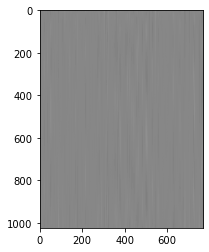

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

plot of 3 weight channels in positional embedding

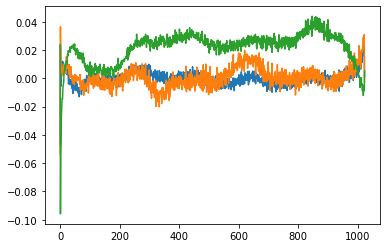

In [6]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

### attention layer

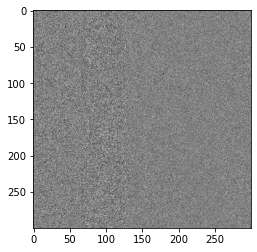

In [7]:
plt.imshow(sd_hf["transformer.h.5.attn.c_attn.weight"][:300,:300], cmap="gray")


### generate text

In [8]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2', device='cuda')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cuda
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so you can\'t define something in any other language. Let me introduce another topic:\n\nThe name "'},
 {'generated_text': "Hello, I'm a language model, you know.\n\nThat's right… I have a lot of friends who don't know what I do"},
 {'generated_text': "Hello, I'm a language model, not a formal one. I'm more interested in languages than formal models and I'm going to use the formal"},
 {'generated_text': "Hello, I'm a language model, which means that if you're a language designer, you need some understanding of the language model so you can build"},
 {'generated_text': "Hello, I'm a language model, and how I learn a language like C is based upon my experience with learning it. My focus is just a"}]

Generate manually to compare with our implementation

In [9]:
# let's instead sample manually
import torch
from torch.nn import functional as F

device = 'cuda'

def generated_seq(model):
    model.eval()
    model.to(device)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
    tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
    tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
    x = tokens.to(device)

    # generate!
    while x.size(1) < 30: # max_length=30
        # forward the model to get the logits
        with torch.no_grad():
            logits = model(x)[0] # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            x = torch.cat((x, xcol), dim=1)

    # print the generated text
    import tiktoken
    enc = tiktoken.get_encoding('gpt2')
    for i in range(5):
        tokens = x[i, :30].tolist()
        decoded = enc.decode(tokens)
        print(">", decoded)

In [10]:
print("HF model")
hf_model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
generated_seq(hf_model)

HF model
> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some


In [11]:
print("My model")
from gpt2 import GPT, GPTConfig

my_model = GPT.from_pretrained('gpt2')
generated_seq(my_model)

My model
loading weights from pretrained gpt: gpt2
> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some


### data prep

In [12]:
# tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [13]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [14]:
import torch
buf = torch.tensor(tokens[:24 + 1])
buf = buf.to(device)
x = buf[:-1].view(4, 6) # input
y = buf[1:].view(4, 6)  # target
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]], device='cuda:0')
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]], device='cuda:0')


### simple train

In [41]:
import time
import torch
torch.manual_seed(1337)

device = 'cuda'

print(f"Device: {device}")
# nice vocab no.
nice_vocab_size = 50304     # nice power of 2
model = GPT(GPTConfig(vocab_size=nice_vocab_size))
model.to(device)
# torch compile
model = torch.compile(model)

# optimize
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# dataloader
from gpt2 import DataLoaderLite
train_loader = DataLoaderLite(B=16, T=1024)

# set computation to TF32 instead of F32
torch.set_float32_matmul_precision('high')

# train loop
for i in range(50):
    t0 = time.time()
    # ata
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    # optim
    optimizer.zero_grad()
    # BF16 mixed precision training
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)
    # step
    loss.backward()
    optimizer.step()

    # instrument
    if device == "cuda":
        torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T
    tokens_per_sec = tokens_processed / dt
    print(f"step {i} | loss: {loss.item()} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")



Device: cuda
Dataset stats:
- 338,024 tokens
- 20 batches per epoch
step 0 | loss: 10.947327613830566 | dt: 13186.24ms | tok/sec: 1242.51
step 1 | loss: 9.388608932495117 | dt: 39.79ms | tok/sec: 411799.64
step 2 | loss: 8.962977409362793 | dt: 40.07ms | tok/sec: 408888.74
step 3 | loss: 8.85222053527832 | dt: 40.32ms | tok/sec: 406362.03
step 4 | loss: 8.505096435546875 | dt: 40.98ms | tok/sec: 399764.26
step 5 | loss: 8.473745346069336 | dt: 40.69ms | tok/sec: 402673.63
step 6 | loss: 8.318779945373535 | dt: 40.49ms | tok/sec: 404636.85
step 7 | loss: 8.07040023803711 | dt: 40.60ms | tok/sec: 403529.60
step 8 | loss: 7.814915180206299 | dt: 40.76ms | tok/sec: 401955.26
step 9 | loss: 7.59152889251709 | dt: 40.85ms | tok/sec: 401068.49
step 10 | loss: 7.390006065368652 | dt: 40.58ms | tok/sec: 403792.79
step 11 | loss: 7.276639461517334 | dt: 40.72ms | tok/sec: 402320.01
step 12 | loss: 7.080596923828125 | dt: 40.78ms | tok/sec: 401717.93
step 13 | loss: 7.013101577758789 | dt: 40.65m

In [40]:
logits.dtype

torch.bfloat16

Speed test:

- GPU vanila    | dt: 379.91ms | tok/sec: 43126.52
- TF32          | dt: 170.49ms | tok/sec: 96098.66
- BF16 mixed precision | dt: 161.31ms | tok/sec: 101567.53
- Torch compile | dt: 58.22ms | tok/sec: 281415.76
- Flash attention | dt: 43.76ms | tok/sec: 374403.29
- nice vocab size | dt: 40.78ms | tok/sec: 401729.68

~10x speed up!!!!

380ms --> 40 ms      
43k tps --> 401k tps



In [35]:
%%bash 
nvidia-smi

Mon Feb 17 06:45:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   33C    P0            137W /  700W |   50510MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### share embeddings test

In [18]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()


print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

torch.Size([50257, 768])
torch.Size([50257, 768])
260721048748096
260721048748096


### std of residual

In [19]:
# standard deviation grows inside the residual stream
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += torch.randn(768) * n**-0.5

print(x.std())

tensor(0.9782)


### Viz train and val loss

Min Train Loss: 3.000695
Min Validation Loss: 3.182
Max Hellaswag eval: 0.3001


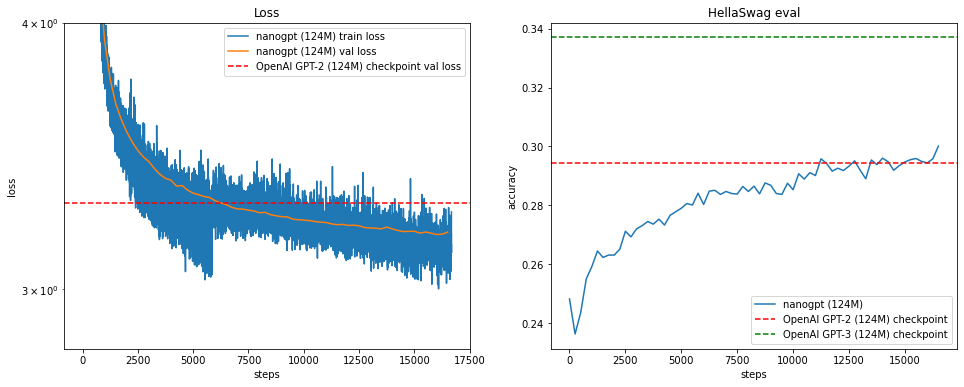

In [9]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))
